### Rotation with cropping

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join, exists, expanduser
from genericpath import isdir
from glob import glob
import numpy as np
from PIL import Image
from collections import defaultdict
import matplotlib.pyplot as plt
import torch
import math

from lib.r2d2.extract import extract_keypoints_modified
from relfm.utils.paths import REPO_PATH
from relfm.utils.log import print_update, tqdm_iterator
from relfm.utils.geometry import (
    append_rotation_to_homography,
    get_image_corners,
    apply_homography_to_keypoints,
    apply_clean_rotation,
    center_crop, 
    resize,
)
from relfm.utils.visualize import (
    show_images_with_keypoints,
    set_latex_fonts, get_colors,
    show_grid_of_images,
    draw_kps_on_image,
)
from relfm.utils.matching import evaluate_matching_with_rotation, analyze_result
from relfm.inference.r2d2_on_hpatches import configure_save_dir

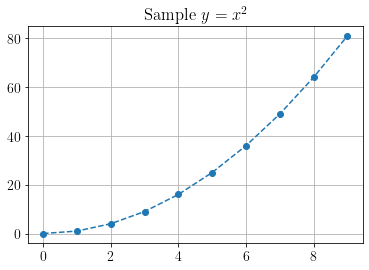

In [3]:
set_latex_fonts(show_sample=True)

In [4]:
def add_margin(pil_img, top, right, bottom, left, color=(0, 0, 0)):
    """Ref: https://note.nkmk.me/en/python-pillow-add-margin-expand-canvas/"""
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [5]:
sequence = "../data/hpatches-sequences-release/i_castle/"

source_img_path = join(sequence, "1.ppm")
source_img = Image.open(source_img_path)

target_img_path = join(sequence, "2.ppm")
target_img = Image.open(target_img_path)

rotation = 45
target_img_rot = target_img.rotate(rotation)

pad = 100
target_img_pad = add_margin(target_img, pad, pad, pad, pad)
target_img_pad_rot = target_img_pad.rotate(rotation)

H = np.loadtxt(join(sequence, "H_1_2"))

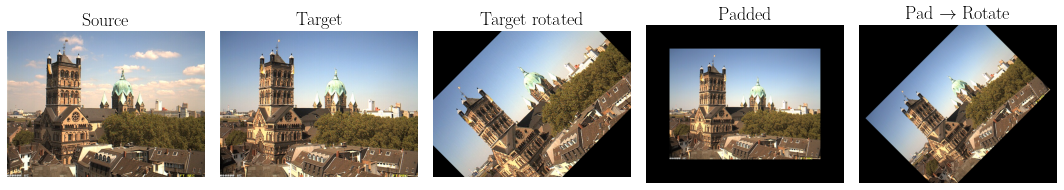

In [6]:
show_grid_of_images(
    [source_img, target_img, target_img_rot, target_img_pad, target_img_pad_rot],
    subtitles=["Source", "Target", "Target rotated", "Padded", "Pad $\\rightarrow$ Rotate"],
    n_cols=5,
    figsize=(15, 3)
)

### Final code

In [7]:
# def center_crop(im, new_width, new_height):
#     width, height = im.size

#     left = (width - new_width)/2
#     top = (height - new_height)/2
#     right = (width + new_width)/2
#     bottom = (height + new_height)/2

#     # Crop the center of the image
#     im = im.crop((left, top, right, bottom))
    
#     H_crop = np.eye(3)
#     H_crop[0, 2] = -left
#     H_crop[1, 2] = -top
    
#     return im, H_crop


# def resize(im, new_width, new_height):
#     width, height = im.size
#     im = im.resize((new_width, new_height))

#     sx = new_width / width
#     sy = new_height / height
#     H_resize = np.array([
#         [sx, 0., 0.],
#         [0., sy, 0.],
#         [0., 0., 1.],
#     ])
    
#     return im, H_resize

In [8]:
image = target_img.copy()
degrees = rotation
rotated = target_img.rotate(degrees)

# apply rotation homography
H_rot = append_rotation_to_homography(H=np.eye(3), rotation=rotation, width=image.size[0], height=image.size[1])

# crop rotated image
# credits: https://stackoverflow.com/questions/21346670/cropping-rotated-image-with-same-aspect-ratio
aspect_ratio = float(image.size[0]) / image.size[1]
rotated_aspect_ratio = float(rotated.size[0]) / rotated.size[1]
angle = math.fabs(degrees) * math.pi / 180

if aspect_ratio < 1:
    total_height = float(image.size[0]) / rotated_aspect_ratio
else:
    total_height = float(image.size[1])

h = total_height / (aspect_ratio * math.sin(angle) + math.cos(angle))
w = h * aspect_ratio

rotated_cropped, H_crop = center_crop(rotated, w, h)

# resize rotated_cropped image to original dimensions
# credits: https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
W, H = image.size
rotated_cropped_resized, H_resize = resize(rotated_cropped, W, H)

In [9]:
assert rotated_cropped_resized.size == image.size

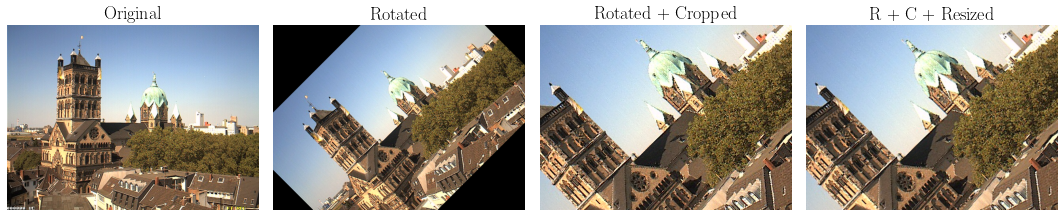

In [10]:
show_grid_of_images(
    [image, rotated, rotated_cropped, rotated_cropped_resized],
    subtitles=["Original", "Rotated", "Rotated + Cropped", "R + C + Resized"],
    figsize=(15, 4),
)

In [11]:
kps = np.array([
    [300., 200.], 
    [200., 300.],
    [300., 400.],
    [400., 400.],
])

kps_rotated = apply_homography_to_keypoints(kps, H_rot)

H_combined = H_crop @ H_rot
# kps_rotated_cropped = apply_homography_to_keypoints(kps_rotated, H_crop)
kps_rotated_cropped = apply_homography_to_keypoints(kps, H_combined)

H_combined = H_resize @ H_crop @ H_rot
kps_rotated_cropped_resized = apply_homography_to_keypoints(kps, H_combined)

In [12]:
H_resize

array([[1.66666667, 0.        , 0.        ],
       [0.        , 1.66666667, 0.        ],
       [0.        , 0.        , 1.        ]])

In [13]:
kps_rotated_cropped

array([[152.7286944 , 130.11401807],
       [152.7286944 , 271.53537431],
       [294.15005064, 271.53537431],
       [364.86072876, 200.82469619]])

In [14]:
kps_rotated_cropped_resized

array([[254.54782401, 216.85669678],
       [254.54782401, 452.55895718],
       [490.2500844 , 452.55895718],
       [608.1012146 , 334.70782698]])

In [15]:
image_with_kps = draw_kps_on_image(image, kps, return_as="PIL", radius=8)
rotated_with_kps = draw_kps_on_image(rotated, kps_rotated, return_as="PIL", radius=8)
rotated_cropped_with_kps = draw_kps_on_image(rotated_cropped, kps_rotated_cropped, return_as="PIL", radius=8)
rotated_cropped_resized_with_kps = draw_kps_on_image(
    rotated_cropped_resized, kps_rotated_cropped_resized, return_as="PIL", radius=8)

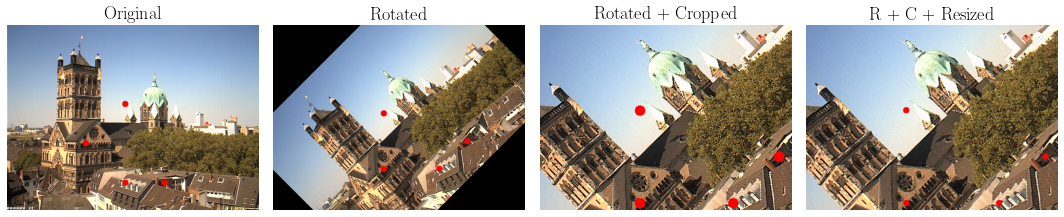

In [16]:
show_grid_of_images(
    [image_with_kps, rotated_with_kps, rotated_cropped_with_kps, rotated_cropped_resized_with_kps],
    subtitles=["Original", "Rotated", "Rotated + Cropped", "R + C + Resized"],
    figsize=(15, 4),
)

### Combining it into one transformation function

In [17]:
# def apply_clean_rotation(image, degrees, H=np.eye(3)):
#     """
#     Applies rotation to an image followed by cropping to clean out black areas.
    
#     Args:
#         image (np.ndarray): input image
#         degrees (int): rotation in degrees
#         H (np.ndarray): homography matrix, (optional) defaults to $I_{3}$
    
#     Returns:
#         (tuple): transformed image and homography
#     """
#     original_width, original_height = image.size
    
#     # rotate the image
#     rotated = image.rotate(degrees)
#     H_rot = append_rotation_to_homography(
#         H=H,
#         rotation=degrees,
#         width=image.size[0],
#         height=image.size[1],
#     )
    
#     # crop rotated image to ignore black areas
#     # credits: https://stackoverflow.com/questions/21346670/cropping-rotated-image-with-same-aspect-ratio
#     aspect_ratio = float(image.size[0]) / image.size[1]
#     rotated_aspect_ratio = float(rotated.size[0]) / rotated.size[1]
#     angle = math.fabs(degrees) * math.pi / 180
#     if aspect_ratio < 1:
#         total_height = float(image.size[0]) / rotated_aspect_ratio
#     else:
#         total_height = float(image.size[1])
#     h = total_height / (aspect_ratio * math.sin(angle) + math.cos(angle))
#     w = h * aspect_ratio
#     rotated_cropped, H_crop = center_crop(rotated, w, h)
    
#     # resize rotated_cropped image to original dimensions
#     # credits: https://stackoverflow.com/questions/16646183/crop-an-image-in-the-centre-using-pil
#     W, H = image.size
#     rotated_cropped_resized, H_resize = resize(rotated_cropped, W, H)
    
#     # combine the homographies
#     H_combined = H_resize @ H_crop @ H_rot
    
#     return rotated_cropped_resized, H_combined

In [20]:
# load sample image
image = Image.open(target_img_path)
H = np.eye(3)

# consider a rotation
degrees = 45

# consider sample keypoints
kps = np.array([
    [300., 200.],
    [200., 300.],
    [300., 400.],
    [400., 400.],
])

# apply the transformation
image_transformed, _, H_transformed = apply_clean_rotation(
    image, degrees, H=H,
)

# draw keypoints on images
kps_on_image = apply_homography_to_keypoints(kps, H)
image_with_kps = draw_kps_on_image(image, kps_on_image, radius=10)

kps_on_image_transformed = apply_homography_to_keypoints(kps_on_image, H_transformed)
image_transformed_with_kps = draw_kps_on_image(image_transformed, kps_on_image_transformed, radius=10)

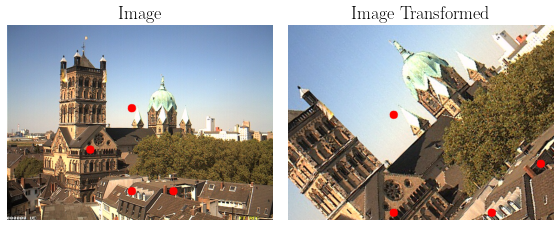

In [21]:
show_grid_of_images(
    images=[image_with_kps, image_transformed_with_kps],
    subtitles=["Image", "Image Transformed"],
)

### Test it on a pair of images

In [22]:
source = Image.open(source_img_path)
target = Image.open(target_img_path)

H = np.loadtxt(join(sequence, "H_1_2"))

In [23]:
def check_kps_with_homography(
        img1, img2, H, kps=None,
        num_kps=10, sample="random", **draw_args,
    ):
    """Checks if H correctly transforms keypoints kps from img1 to img2."""
    if kps is None:
        width, height = img1.size
        assert sample in ["random", "uniform"]
        
        if sample == "random":
            np.random.seed(0)
            kps = np.vstack(
                [np.random.randint(0, width, num_kps), np.random.randint(0, height, num_kps)]
            ).T
        elif sample == "uniform":
            x = np.linspace(0, width, num_kps)
            y = np.linspace(0, height, num_kps)
            X, Y = np.meshgrid(x, y)

            kps = []
            for i in range(num_kps):
                for j in range(num_kps):
                    kps.append([X[i, j], Y[i, j]])
            kps = np.array(kps)
    
    img1_with_kps = draw_kps_on_image(img1, kps, **draw_args)
    
    kps_transformed = apply_homography_to_keypoints(kps, H)
    img2_with_kps = draw_kps_on_image(img2, kps_transformed, **draw_args)

    show_grid_of_images(
        images=[img1_with_kps, img2_with_kps],
        subtitles=["Source", "Target (Transformation: $H$)"],
    )

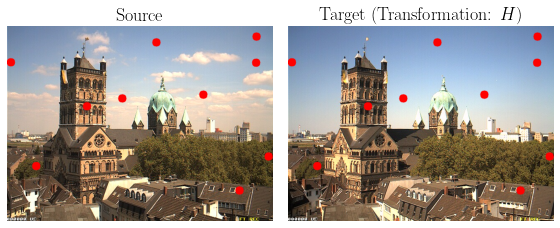

In [24]:
check_kps_with_homography(source, target, H, radius=10)

In [25]:
degrees = 45

#### Apply on source and sanity-check

In [40]:
_, _, source_transformed, H_source = apply_clean_rotation(image=source, degrees=degrees, H=np.eye(3))

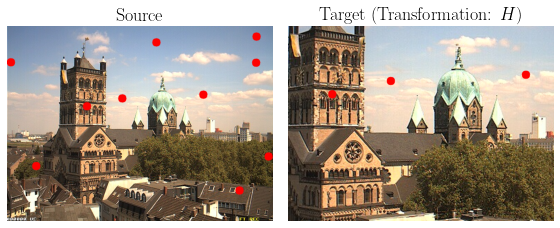

In [41]:
check_kps_with_homography(source, source_transformed, H_source, radius=10)

#### Apply on target and sanity-check

In [42]:
target_transformed, H_target, _, _  = apply_clean_rotation(image=target, degrees=degrees, H=np.eye(3))

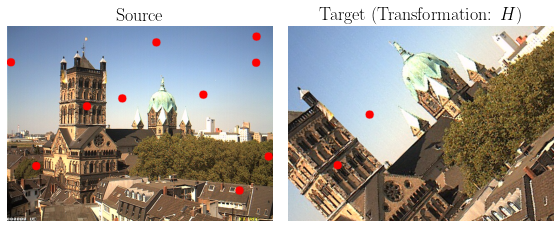

In [43]:
check_kps_with_homography(target, target_transformed, H_target, radius=10)

#### Combine

In [44]:
H_together = H_target @ H @ np.linalg.inv(H_source)

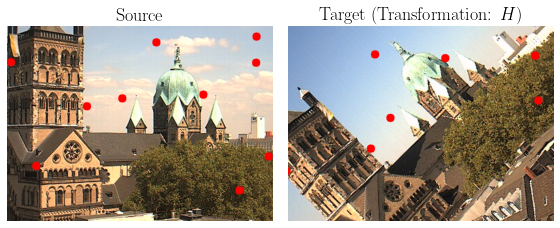

In [47]:
check_kps_with_homography(source_transformed, target_transformed, H_together, radius=10)